In [21]:
#% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Import All Training Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.

# Import Midi files to list
Working_Directory = os.getcwd()
Training_Midi_Folder = Working_Directory + "/Midi_Files/Bach_Handpicked"
max_time_steps = 256 # only files atleast this many 16th note steps are saved

practice_batch_size = 15
practice_num_timesteps = 128


training_pieces = multi_training.loadPieces(Training_Midi_Folder, max_time_steps)
print('')
print('Number of training pieces = ', len(training_pieces))

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)


Skip bad file =  Fugue12
Loaded Fugue8
Loaded Fugue22
Loaded Fugue18
Loaded Fugue5
Skip bad file =  Fugue19
Loaded Fugue4
Loaded Fugue17
Loaded Fugue9 (1)
Loaded Fugue7 (1)
Loaded Fugue3
Loaded Fugue7
Loaded Fugue16
Loaded Fugue3 (1)
Loaded Fugue12 (1)
Loaded Fugue5 (1)
Skip bad file =  Fugue13
Skip bad file =  Fugue15
Loaded Fugue1
Skip bad file =  Fugue6
Loaded Fugue1 (1)
Loaded Fugue20
Skip bad file =  Fugue11
Loaded Fugue8 (1)
Loaded Fugue23
Loaded Fugue2
Loaded Fugue24
Loaded Fugue9

Number of training pieces =  22
Sample of State Input Batch: shape =  (15, 78, 128, 2)


In [30]:
# Beginning of Model Graph:
tf.reset_default_graph()

#input_size = sample_state.shape[-1]
num_notes = sample_state.shape[1]


#place holder inputs
# num_batches and num_time steps are variable lengths.  These values do not affect the model parameters
# Dimension(0) =  num_batches. Dimension(2) = num_time_steps

#final_t_sample_run = np.zeros((batch_size, num_notes, 1, 2)) #start every batch with zero previous input


        
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
#prev_t_sample = tf.placeholder(dtype=tf.float32, shape=[None, num_notes,1,2])
time_init = tf.placeholder(dtype=tf.int32, shape=())
#Generates expanded tensor input to LSTM-timewise layer
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Batch Placeholder Shape = ', Note_State_Batch.get_shape())
print('Note_State_Expand output Shape = ', Note_State_Expand.get_shape())





Note_State_Batch Placeholder Shape =  (?, 78, ?, 2)
Note_State_Expand output Shape =  (?, 78, ?, 80)


In [31]:
# Check Input Kernel on sample data

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sample_expand = sess.run(Note_State_Expand, feed_dict={Note_State_Batch: sample_state, time_init: 1})



#check MIDI note
print('sample_expand shape = ', sample_expand.shape)
print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_1, t_0 = ', sample_expand[0,1,0,[0]])  
print('MIDI note_2, t_0 = ', sample_expand[0,2,0,[0]]) 

print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_0, t_1 = ', sample_expand[0,0,1,[0]])  
print('MIDI note_0, t_29 = ', sample_expand[0,0,29,[0]]) 
print('') 

#check pitchclass
print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_1, t_0 = ', sample_expand[0,1,0,1:13])  
print('pitchclass note_11, t_0 = ', sample_expand[0,11,0,1:13]) 

print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_0, t_1 = ', sample_expand[0,0,1,1:13])  
print('pitchclass note_0, t_29 = ', sample_expand[0,0,29,1:13]) 
print('') 

#check vicinity
print('sample state local vicinity = ', sample_state[0,33:58,29,:])
print('calculated vicinity note_45, t_29 = ', sample_expand[0,45,29,13:63])
print('')

#check  context
print('calculated context note_45, t_29 = ', sample_expand[0,45,29,63:75])
print('actual all note plays at, t_29 = ', sample_state[0,:,29,0])
print('')

#check beat
print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_1, t_0 = ', sample_expand[0,1,0,75:79])  
print('beat note_2, t_0 = ', sample_expand[0,2,0,75:79]) 

print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_0, t_1 = ', sample_expand[0,0,1,75:79])  
print('beat note_0, t_29 = ', sample_expand[0,0,29,75:79]) 
print('')


sample_expand shape =  (15, 78, 128, 80)
MIDI note_0, t_0 =  [ 24.]
MIDI note_1, t_0 =  [ 25.]
MIDI note_2, t_0 =  [ 26.]
MIDI note_0, t_0 =  [ 24.]
MIDI note_0, t_1 =  [ 24.]
MIDI note_0, t_29 =  [ 24.]

pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_1, t_0 =  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_11, t_0 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_1 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_29 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

sample state local vicinity =  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
calculated vicinity note_45, t_29 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  0

In [32]:
#lSTM Time Wise Training Graph 
#tf.reset_default_graph()
#Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 80])
#Note_State_Expand_val = np.ones((10,78,128,80))

num_t_units=[200, 200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)


print('Time-wise output shape = ', timewise_out.get_shape())
print(len(timewise_state_out))



Time-wise output shape =  (?, 78, ?, 200)
2


In [33]:
#LSTM Note Wise Graph
#tf.reset_default_graph()
#num_notes=78
#Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
#Note_State_Batch_val = np.zeros((10,78,128,2))
#timewise_out = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 50])
#output_keep_prob=1
num_n_units = [100, 100]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)

p_out = tf.sigmoid(y_out)
print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())




y_out shape =  (?, 78, ?, 2)
generated samples shape =  (?, 78, ?, 2)


In [221]:
# Test for Notewise-LSTM
#num_timesteps=5
#batch_size=7
#timewise_out_val = np.random.randn(batch_size, 78, num_timesteps, 50)*10

notewise_state_val=[]
for i in range(len(num_n_units)):
    c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h_n, c_n))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {timewise_out: timewise_out_val, notewise_state: notewise_state_val}
    y_out_run, note_gen_out_run, p_out_run = sess.run([y_out, note_gen_out, p_out], feed_dict=feed_dict)


In [223]:

print(p_out_run[0,1:10,0,:])

[[ 0.57015109  0.37799257]
 [ 0.56050414  0.28474435]
 [ 0.81526381  0.51652592]
 [ 0.51000327  0.47562233]
 [ 0.45483524  0.42948249]
 [ 0.41522047  0.58680546]
 [ 0.34573999  0.39803994]
 [ 0.64800113  0.63286799]
 [ 0.58131123  0.69331133]]


In [34]:
# Loss Function and Optimizer

#y_out_val = np.random.randn(1, 78, 128, 2, 2)*5


loss, log_likelihood = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)






Note_State_Batch:  Tensor("Placeholder:0", shape=(?, 78, ?, 2), dtype=float32)


In [ ]:
# Test for Loss Graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cross_entropy_out, loss_out = sess.run([cross_entropy, loss], feed_dict={Note_State_Batch: Note_State_Batch_val, timewise_out: timewise_out_val, notewise_state: notewise_state_val})

    
print('cross entropy out shape = ', cross_entropy_out.shape)
print('loss = ', loss_out)

In [36]:
# Training
N_epochs = 2000
loss_hist=[]
restore_model_name = None
save_model_name = 'Practice_sigmoid'
batch_size = 10
num_timesteps = 128
keep_prob=.75

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, 'model/{}'.format(restore_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs+1):
        
        #Generate random batch of training data        
        if (epoch % 100 == 0):         
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
            #print('sum = ',sum(sum(sum(sum(batch_input_state)))) )
        
        """
        print('Note_State_Batch shape = ', Note_State_Batch.get_shape())
        print('batch_input_state shape = ', batch_input_state.shape)
        print('')
        print('timewise_state shape = ', Note_State_Batch.get_shape())
        print('timewise_state_val shape = ', batch_input_state.shape)      
        print('')
        print('notewise_state shape = ', Note_State_Batch.get_shape())
        print('notewise_state_val shape = ', batch_input_state.shape)
        ('')
        print('time_init shape = ', time_init.get_shape())
        """
    
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        #try:
        loss_run, log_likelihood_run, _, note_gen_out_run = sess.run([loss, log_likelihood, optimizer, note_gen_out], feed_dict=feed_dict)
        #except:
        #   save_path = saver.save(sess, 'model/{}'.format(save_model_name))
        #    print("Model saved in file: %s" % save_path)
        print('epoch = ', epoch, '; loss = ', loss_run, '; scaled log likelihood = ', log_likelihood_run)
        loss_hist.append(loss_run)
        
        if (epoch % 500 ==0):
            error = sum(sum(sum(abs(batch_input_state[:,:,1:,:] - note_gen_out_run[:,:,:-1,:]))))
            num_1 = sum(sum(sum(abs(batch_input_state[:,:,1:,:]))))
            print('error = ', error)
            print('num_1 = ', num_1)
        if (epoch % 100 == 0) & (epoch > 0):
            save_path = saver.save(sess, 'model/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            
    #save_path = saver.save(sess, 'model/{}'.format(save_model_name))
    #print(" Final Model saved in file: %s" % save_path)


Obtaining new batch of pieces
epoch =  0 ; loss =  0.730939 ; scaled log likelihood =  -57.0133
error =  [49618 25895]
num_1 =  [3827 1805]
epoch =  1 ; loss =  0.701277 ; scaled log likelihood =  -54.6996
epoch =  2 ; loss =  0.67969 ; scaled log likelihood =  -53.0159
epoch =  3 ; loss =  0.659703 ; scaled log likelihood =  -51.4568
epoch =  4 ; loss =  0.640526 ; scaled log likelihood =  -49.9611
epoch =  5 ; loss =  0.623147 ; scaled log likelihood =  -48.6055
epoch =  6 ; loss =  0.604766 ; scaled log likelihood =  -47.1718
epoch =  7 ; loss =  0.58751 ; scaled log likelihood =  -45.8258
epoch =  8 ; loss =  0.57112 ; scaled log likelihood =  -44.5474
epoch =  9 ; loss =  0.553675 ; scaled log likelihood =  -43.1866
epoch =  10 ; loss =  0.53681 ; scaled log likelihood =  -41.8712
epoch =  11 ; loss =  0.520928 ; scaled log likelihood =  -40.6324
epoch =  12 ; loss =  0.50458 ; scaled log likelihood =  -39.3572
epoch =  13 ; loss =  0.49015 ; scaled log likelihood =  -38.2317
epoc

epoch =  121 ; loss =  0.18751 ; scaled log likelihood =  -14.6258
epoch =  122 ; loss =  0.186097 ; scaled log likelihood =  -14.5155
epoch =  123 ; loss =  0.186073 ; scaled log likelihood =  -14.5137
epoch =  124 ; loss =  0.186433 ; scaled log likelihood =  -14.5418
epoch =  125 ; loss =  0.186041 ; scaled log likelihood =  -14.5112
epoch =  126 ; loss =  0.185191 ; scaled log likelihood =  -14.4449
epoch =  127 ; loss =  0.184565 ; scaled log likelihood =  -14.3961
epoch =  128 ; loss =  0.185458 ; scaled log likelihood =  -14.4658
epoch =  129 ; loss =  0.184898 ; scaled log likelihood =  -14.422
epoch =  130 ; loss =  0.185704 ; scaled log likelihood =  -14.4849
epoch =  131 ; loss =  0.184223 ; scaled log likelihood =  -14.3694
epoch =  132 ; loss =  0.184785 ; scaled log likelihood =  -14.4132
epoch =  133 ; loss =  0.183945 ; scaled log likelihood =  -14.3477
epoch =  134 ; loss =  0.184465 ; scaled log likelihood =  -14.3883
epoch =  135 ; loss =  0.184099 ; scaled log likel

epoch =  241 ; loss =  0.169589 ; scaled log likelihood =  -13.228
epoch =  242 ; loss =  0.169162 ; scaled log likelihood =  -13.1946
epoch =  243 ; loss =  0.169492 ; scaled log likelihood =  -13.2204
epoch =  244 ; loss =  0.169815 ; scaled log likelihood =  -13.2455
epoch =  245 ; loss =  0.169044 ; scaled log likelihood =  -13.1854
epoch =  246 ; loss =  0.169844 ; scaled log likelihood =  -13.2478
epoch =  247 ; loss =  0.169257 ; scaled log likelihood =  -13.202
epoch =  248 ; loss =  0.16903 ; scaled log likelihood =  -13.1843
epoch =  249 ; loss =  0.168709 ; scaled log likelihood =  -13.1593
epoch =  250 ; loss =  0.16876 ; scaled log likelihood =  -13.1633
epoch =  251 ; loss =  0.16982 ; scaled log likelihood =  -13.246
epoch =  252 ; loss =  0.168939 ; scaled log likelihood =  -13.1772
epoch =  253 ; loss =  0.16813 ; scaled log likelihood =  -13.1141
epoch =  254 ; loss =  0.168923 ; scaled log likelihood =  -13.176
epoch =  255 ; loss =  0.169018 ; scaled log likelihood 

epoch =  361 ; loss =  0.173568 ; scaled log likelihood =  -13.5383
epoch =  362 ; loss =  0.174171 ; scaled log likelihood =  -13.5853
epoch =  363 ; loss =  0.174535 ; scaled log likelihood =  -13.6137
epoch =  364 ; loss =  0.173862 ; scaled log likelihood =  -13.5612
epoch =  365 ; loss =  0.173931 ; scaled log likelihood =  -13.5666
epoch =  366 ; loss =  0.173396 ; scaled log likelihood =  -13.5249
epoch =  367 ; loss =  0.173131 ; scaled log likelihood =  -13.5042
epoch =  368 ; loss =  0.173738 ; scaled log likelihood =  -13.5516
epoch =  369 ; loss =  0.173027 ; scaled log likelihood =  -13.4961
epoch =  370 ; loss =  0.173448 ; scaled log likelihood =  -13.529
epoch =  371 ; loss =  0.172737 ; scaled log likelihood =  -13.4735
epoch =  372 ; loss =  0.173475 ; scaled log likelihood =  -13.531
epoch =  373 ; loss =  0.173271 ; scaled log likelihood =  -13.5152
epoch =  374 ; loss =  0.174082 ; scaled log likelihood =  -13.5784
epoch =  375 ; loss =  0.173544 ; scaled log likel

epoch =  481 ; loss =  0.164539 ; scaled log likelihood =  -12.834
epoch =  482 ; loss =  0.163959 ; scaled log likelihood =  -12.7888
epoch =  483 ; loss =  0.164134 ; scaled log likelihood =  -12.8025
epoch =  484 ; loss =  0.163868 ; scaled log likelihood =  -12.7817
epoch =  485 ; loss =  0.163996 ; scaled log likelihood =  -12.7917
epoch =  486 ; loss =  0.163534 ; scaled log likelihood =  -12.7556
epoch =  487 ; loss =  0.163877 ; scaled log likelihood =  -12.7824
epoch =  488 ; loss =  0.163656 ; scaled log likelihood =  -12.7652
epoch =  489 ; loss =  0.164295 ; scaled log likelihood =  -12.815
epoch =  490 ; loss =  0.16368 ; scaled log likelihood =  -12.7671
epoch =  491 ; loss =  0.163907 ; scaled log likelihood =  -12.7847
epoch =  492 ; loss =  0.164004 ; scaled log likelihood =  -12.7923
epoch =  493 ; loss =  0.163922 ; scaled log likelihood =  -12.7859
epoch =  494 ; loss =  0.164263 ; scaled log likelihood =  -12.8125
epoch =  495 ; loss =  0.16353 ; scaled log likelih

epoch =  600 ; loss =  0.173175 ; scaled log likelihood =  -13.5076
Model saved in file: model/Practice_sigmoid
epoch =  601 ; loss =  0.172218 ; scaled log likelihood =  -13.433
epoch =  602 ; loss =  0.171815 ; scaled log likelihood =  -13.4015
epoch =  603 ; loss =  0.171577 ; scaled log likelihood =  -13.383
epoch =  604 ; loss =  0.171909 ; scaled log likelihood =  -13.4089
epoch =  605 ; loss =  0.170998 ; scaled log likelihood =  -13.3378
epoch =  606 ; loss =  0.171388 ; scaled log likelihood =  -13.3683
epoch =  607 ; loss =  0.171177 ; scaled log likelihood =  -13.3518
epoch =  608 ; loss =  0.170683 ; scaled log likelihood =  -13.3133
epoch =  609 ; loss =  0.169958 ; scaled log likelihood =  -13.2567
epoch =  610 ; loss =  0.170242 ; scaled log likelihood =  -13.2788
epoch =  611 ; loss =  0.169954 ; scaled log likelihood =  -13.2564
epoch =  612 ; loss =  0.170561 ; scaled log likelihood =  -13.3038
epoch =  613 ; loss =  0.17048 ; scaled log likelihood =  -13.2974
epoch =

epoch =  720 ; loss =  0.171284 ; scaled log likelihood =  -13.3601
epoch =  721 ; loss =  0.171007 ; scaled log likelihood =  -13.3385
epoch =  722 ; loss =  0.170957 ; scaled log likelihood =  -13.3347
epoch =  723 ; loss =  0.172071 ; scaled log likelihood =  -13.4215
epoch =  724 ; loss =  0.171626 ; scaled log likelihood =  -13.3868
epoch =  725 ; loss =  0.171568 ; scaled log likelihood =  -13.3823
epoch =  726 ; loss =  0.171146 ; scaled log likelihood =  -13.3494
epoch =  727 ; loss =  0.171906 ; scaled log likelihood =  -13.4086
epoch =  728 ; loss =  0.171286 ; scaled log likelihood =  -13.3603
epoch =  729 ; loss =  0.171344 ; scaled log likelihood =  -13.3649
epoch =  730 ; loss =  0.17125 ; scaled log likelihood =  -13.3575
epoch =  731 ; loss =  0.170878 ; scaled log likelihood =  -13.3285
epoch =  732 ; loss =  0.17127 ; scaled log likelihood =  -13.3591
epoch =  733 ; loss =  0.171245 ; scaled log likelihood =  -13.3571
epoch =  734 ; loss =  0.170583 ; scaled log likel

epoch =  840 ; loss =  0.166362 ; scaled log likelihood =  -12.9763
epoch =  841 ; loss =  0.167034 ; scaled log likelihood =  -13.0287
epoch =  842 ; loss =  0.16705 ; scaled log likelihood =  -13.0299
epoch =  843 ; loss =  0.167122 ; scaled log likelihood =  -13.0356
epoch =  844 ; loss =  0.166981 ; scaled log likelihood =  -13.0245
epoch =  845 ; loss =  0.166754 ; scaled log likelihood =  -13.0068
epoch =  846 ; loss =  0.167024 ; scaled log likelihood =  -13.0279
epoch =  847 ; loss =  0.166997 ; scaled log likelihood =  -13.0258
epoch =  848 ; loss =  0.166536 ; scaled log likelihood =  -12.9898
epoch =  849 ; loss =  0.167014 ; scaled log likelihood =  -13.0271
epoch =  850 ; loss =  0.166265 ; scaled log likelihood =  -12.9686
epoch =  851 ; loss =  0.16725 ; scaled log likelihood =  -13.0455
epoch =  852 ; loss =  0.166896 ; scaled log likelihood =  -13.0179
epoch =  853 ; loss =  0.166961 ; scaled log likelihood =  -13.0229
epoch =  854 ; loss =  0.166504 ; scaled log likel

epoch =  960 ; loss =  0.165337 ; scaled log likelihood =  -12.8963
epoch =  961 ; loss =  0.16466 ; scaled log likelihood =  -12.8435
epoch =  962 ; loss =  0.164286 ; scaled log likelihood =  -12.8143
epoch =  963 ; loss =  0.165557 ; scaled log likelihood =  -12.9134
epoch =  964 ; loss =  0.164463 ; scaled log likelihood =  -12.8281
epoch =  965 ; loss =  0.164768 ; scaled log likelihood =  -12.8519
epoch =  966 ; loss =  0.164846 ; scaled log likelihood =  -12.858
epoch =  967 ; loss =  0.165583 ; scaled log likelihood =  -12.9155
epoch =  968 ; loss =  0.164432 ; scaled log likelihood =  -12.8257
epoch =  969 ; loss =  0.164917 ; scaled log likelihood =  -12.8635
epoch =  970 ; loss =  0.165515 ; scaled log likelihood =  -12.9102
epoch =  971 ; loss =  0.164894 ; scaled log likelihood =  -12.8618
epoch =  972 ; loss =  0.165693 ; scaled log likelihood =  -12.924
epoch =  973 ; loss =  0.165185 ; scaled log likelihood =  -12.8844
epoch =  974 ; loss =  0.165462 ; scaled log likeli

epoch =  1079 ; loss =  0.162838 ; scaled log likelihood =  -12.7014
epoch =  1080 ; loss =  0.162692 ; scaled log likelihood =  -12.69
epoch =  1081 ; loss =  0.162169 ; scaled log likelihood =  -12.6492
epoch =  1082 ; loss =  0.16255 ; scaled log likelihood =  -12.6789
epoch =  1083 ; loss =  0.163168 ; scaled log likelihood =  -12.7271
epoch =  1084 ; loss =  0.161917 ; scaled log likelihood =  -12.6296
epoch =  1085 ; loss =  0.162932 ; scaled log likelihood =  -12.7087
epoch =  1086 ; loss =  0.161726 ; scaled log likelihood =  -12.6146
epoch =  1087 ; loss =  0.161993 ; scaled log likelihood =  -12.6355
epoch =  1088 ; loss =  0.162751 ; scaled log likelihood =  -12.6946
epoch =  1089 ; loss =  0.162377 ; scaled log likelihood =  -12.6654
epoch =  1090 ; loss =  0.161797 ; scaled log likelihood =  -12.6202
epoch =  1091 ; loss =  0.162276 ; scaled log likelihood =  -12.6575
epoch =  1092 ; loss =  0.162189 ; scaled log likelihood =  -12.6508
epoch =  1093 ; loss =  0.161696 ; sc

epoch =  1198 ; loss =  0.15601 ; scaled log likelihood =  -12.1688
epoch =  1199 ; loss =  0.155527 ; scaled log likelihood =  -12.1311
Obtaining new batch of pieces
epoch =  1200 ; loss =  0.163403 ; scaled log likelihood =  -12.7454
Model saved in file: model/Practice_sigmoid
epoch =  1201 ; loss =  0.161707 ; scaled log likelihood =  -12.6131
epoch =  1202 ; loss =  0.16078 ; scaled log likelihood =  -12.5408
epoch =  1203 ; loss =  0.160715 ; scaled log likelihood =  -12.5357
epoch =  1204 ; loss =  0.160082 ; scaled log likelihood =  -12.4864
epoch =  1205 ; loss =  0.159203 ; scaled log likelihood =  -12.4178
epoch =  1206 ; loss =  0.159772 ; scaled log likelihood =  -12.4622
epoch =  1207 ; loss =  0.15944 ; scaled log likelihood =  -12.4363
epoch =  1208 ; loss =  0.158814 ; scaled log likelihood =  -12.3875
epoch =  1209 ; loss =  0.158436 ; scaled log likelihood =  -12.358
epoch =  1210 ; loss =  0.15887 ; scaled log likelihood =  -12.3919
epoch =  1211 ; loss =  0.157793 ;

epoch =  1316 ; loss =  0.167902 ; scaled log likelihood =  -13.0963
epoch =  1317 ; loss =  0.167647 ; scaled log likelihood =  -13.0764
epoch =  1318 ; loss =  0.167243 ; scaled log likelihood =  -13.045
epoch =  1319 ; loss =  0.167438 ; scaled log likelihood =  -13.0601
epoch =  1320 ; loss =  0.16708 ; scaled log likelihood =  -13.0322
epoch =  1321 ; loss =  0.167365 ; scaled log likelihood =  -13.0545
epoch =  1322 ; loss =  0.167019 ; scaled log likelihood =  -13.0275
epoch =  1323 ; loss =  0.167039 ; scaled log likelihood =  -13.0291
epoch =  1324 ; loss =  0.167154 ; scaled log likelihood =  -13.038
epoch =  1325 ; loss =  0.167032 ; scaled log likelihood =  -13.0285
epoch =  1326 ; loss =  0.166743 ; scaled log likelihood =  -13.006
epoch =  1327 ; loss =  0.166865 ; scaled log likelihood =  -13.0154
epoch =  1328 ; loss =  0.166506 ; scaled log likelihood =  -12.9875
epoch =  1329 ; loss =  0.167306 ; scaled log likelihood =  -13.0499
epoch =  1330 ; loss =  0.167099 ; sca

epoch =  1435 ; loss =  0.165046 ; scaled log likelihood =  -12.8736
epoch =  1436 ; loss =  0.164726 ; scaled log likelihood =  -12.8487
epoch =  1437 ; loss =  0.164655 ; scaled log likelihood =  -12.8431
epoch =  1438 ; loss =  0.164619 ; scaled log likelihood =  -12.8403
epoch =  1439 ; loss =  0.164283 ; scaled log likelihood =  -12.8141
epoch =  1440 ; loss =  0.165273 ; scaled log likelihood =  -12.8913
epoch =  1441 ; loss =  0.164785 ; scaled log likelihood =  -12.8532
epoch =  1442 ; loss =  0.164535 ; scaled log likelihood =  -12.8337
epoch =  1443 ; loss =  0.164284 ; scaled log likelihood =  -12.8142
epoch =  1444 ; loss =  0.164095 ; scaled log likelihood =  -12.7994
epoch =  1445 ; loss =  0.164497 ; scaled log likelihood =  -12.8308
epoch =  1446 ; loss =  0.164294 ; scaled log likelihood =  -12.815
epoch =  1447 ; loss =  0.163901 ; scaled log likelihood =  -12.7843
epoch =  1448 ; loss =  0.164017 ; scaled log likelihood =  -12.7933
epoch =  1449 ; loss =  0.163968 ; 

epoch =  1553 ; loss =  0.164715 ; scaled log likelihood =  -12.8478
epoch =  1554 ; loss =  0.163999 ; scaled log likelihood =  -12.7919
epoch =  1555 ; loss =  0.164167 ; scaled log likelihood =  -12.805
epoch =  1556 ; loss =  0.164705 ; scaled log likelihood =  -12.847
epoch =  1557 ; loss =  0.164261 ; scaled log likelihood =  -12.8123
epoch =  1558 ; loss =  0.164072 ; scaled log likelihood =  -12.7976
epoch =  1559 ; loss =  0.164322 ; scaled log likelihood =  -12.8171
epoch =  1560 ; loss =  0.164262 ; scaled log likelihood =  -12.8124
epoch =  1561 ; loss =  0.164516 ; scaled log likelihood =  -12.8323
epoch =  1562 ; loss =  0.164168 ; scaled log likelihood =  -12.8051
epoch =  1563 ; loss =  0.164109 ; scaled log likelihood =  -12.8005
epoch =  1564 ; loss =  0.164058 ; scaled log likelihood =  -12.7965
epoch =  1565 ; loss =  0.163889 ; scaled log likelihood =  -12.7834
epoch =  1566 ; loss =  0.164409 ; scaled log likelihood =  -12.8239
epoch =  1567 ; loss =  0.164302 ; s

epoch =  1672 ; loss =  0.167012 ; scaled log likelihood =  -13.0269
epoch =  1673 ; loss =  0.166379 ; scaled log likelihood =  -12.9776
epoch =  1674 ; loss =  0.166055 ; scaled log likelihood =  -12.9523
epoch =  1675 ; loss =  0.166643 ; scaled log likelihood =  -12.9982
epoch =  1676 ; loss =  0.166513 ; scaled log likelihood =  -12.988
epoch =  1677 ; loss =  0.166586 ; scaled log likelihood =  -12.9937
epoch =  1678 ; loss =  0.166148 ; scaled log likelihood =  -12.9596
epoch =  1679 ; loss =  0.166034 ; scaled log likelihood =  -12.9507
epoch =  1680 ; loss =  0.166266 ; scaled log likelihood =  -12.9688
epoch =  1681 ; loss =  0.166661 ; scaled log likelihood =  -12.9996
epoch =  1682 ; loss =  0.166505 ; scaled log likelihood =  -12.9874
epoch =  1683 ; loss =  0.166303 ; scaled log likelihood =  -12.9716
epoch =  1684 ; loss =  0.165841 ; scaled log likelihood =  -12.9356
epoch =  1685 ; loss =  0.166456 ; scaled log likelihood =  -12.9836
epoch =  1686 ; loss =  0.166416 ; 

epoch =  1790 ; loss =  0.165734 ; scaled log likelihood =  -12.9272
epoch =  1791 ; loss =  0.16507 ; scaled log likelihood =  -12.8755
epoch =  1792 ; loss =  0.164405 ; scaled log likelihood =  -12.8236
epoch =  1793 ; loss =  0.165537 ; scaled log likelihood =  -12.9119
epoch =  1794 ; loss =  0.165121 ; scaled log likelihood =  -12.8794
epoch =  1795 ; loss =  0.165444 ; scaled log likelihood =  -12.9046
epoch =  1796 ; loss =  0.165346 ; scaled log likelihood =  -12.897
epoch =  1797 ; loss =  0.165222 ; scaled log likelihood =  -12.8873
epoch =  1798 ; loss =  0.165289 ; scaled log likelihood =  -12.8925
epoch =  1799 ; loss =  0.16485 ; scaled log likelihood =  -12.8583
Obtaining new batch of pieces
epoch =  1800 ; loss =  0.167377 ; scaled log likelihood =  -13.0554
Model saved in file: model/Practice_sigmoid
epoch =  1801 ; loss =  0.16597 ; scaled log likelihood =  -12.9457
epoch =  1802 ; loss =  0.164643 ; scaled log likelihood =  -12.8421
epoch =  1803 ; loss =  0.163651 

epoch =  1908 ; loss =  0.162552 ; scaled log likelihood =  -12.6791
epoch =  1909 ; loss =  0.163111 ; scaled log likelihood =  -12.7227
epoch =  1910 ; loss =  0.162569 ; scaled log likelihood =  -12.6804
epoch =  1911 ; loss =  0.16281 ; scaled log likelihood =  -12.6992
epoch =  1912 ; loss =  0.162327 ; scaled log likelihood =  -12.6615
epoch =  1913 ; loss =  0.162083 ; scaled log likelihood =  -12.6425
epoch =  1914 ; loss =  0.162179 ; scaled log likelihood =  -12.65
epoch =  1915 ; loss =  0.161984 ; scaled log likelihood =  -12.6347
epoch =  1916 ; loss =  0.161859 ; scaled log likelihood =  -12.625
epoch =  1917 ; loss =  0.162132 ; scaled log likelihood =  -12.6463
epoch =  1918 ; loss =  0.161655 ; scaled log likelihood =  -12.6091
epoch =  1919 ; loss =  0.161341 ; scaled log likelihood =  -12.5846
epoch =  1920 ; loss =  0.161227 ; scaled log likelihood =  -12.5757
epoch =  1921 ; loss =  0.161249 ; scaled log likelihood =  -12.5775
epoch =  1922 ; loss =  0.161538 ; sca

In [27]:


#print(square_error/mag)
#print('Actual input = ', batch_input_state[:,:,1,:])
#print('Output predicting this input = ', note_gen_out_run[:,:,0,:])
error = sum(sum(sum(abs(batch_input_state[:,:,1:,:] - note_gen_out_run[:,:,:-1,:]))))
num_1 = sum(sum(sum(abs(batch_input_state[:,:,1:,:]))))
print('error = ', error)
print('num_1 = ', num_1)
#for v in range(len(tf.trainable_variables())):
#    print(tf.trainable_variables()[v])

error =  [3520 1723]
num_1 =  [3824 1511]


In [20]:
(1000 % 100 == 0) & (1000 > 0)


True

2001

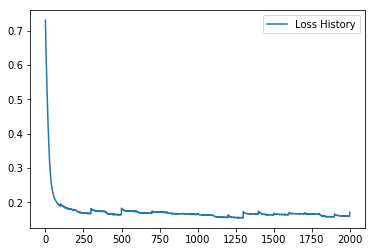

In [37]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [38]:
# Music Generation
# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files


#Load Model
restore_model_name = 'Practice_sigmoid'

#Length of generated music
T_gen = 16*16
batch_gen_size = 5
keep_prob = 1

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start first time step with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(restore_model_name))
    saver.restore(sess, 'model/{}'.format(restore_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        #print('notes_gen shape = ', notes_gen.shape)
        #notes_gen = np.squeeze(notes_gen, axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    
notes_gen_out = np.stack(notes_gen_arr, axis=2)
print(notes_gen_out.shape)
        


Load the model from: Practice_sigmoid
INFO:tensorflow:Restoring parameters from model/Practice_sigmoid
Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
(5, 78, 256, 2)


In [39]:
# Save Generate Notes to .MIDI file

notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
print(notes_gen_out.shape)
#_, notes_gen_out = Utils.multi_training.getPieceBatch(training_pieces)


#print(test_batch.shape)
for iter in range(4):
    file = 'Generated_Midi_Files/Practice_sigmoid' + str(iter)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)

(5, 256, 78, 2)


Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- use encoder to reduce dimensionality of each note vector (vector of 79 notes in 1 time step), similiar to encoding the words from the tweets in homework 3 (i.e. there are restricted combinations of notes that can be played simultaneously)
- more advanced sampling/exploring for training/music generation.  This may help prevent the algorithm from getting 'stuck' on a chord, or 